In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from PIL import Image
import os
import re
import csv

In [13]:
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

In [14]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.


def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()


def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def process_images_in_folder(input_folder):
    processed_images = []

    # Get a sorted list of image files in the folder using natural sorting
    image_files = sorted([filename for filename in os.listdir(input_folder) if filename.endswith(('.jpg', '.jpeg', '.png'))], key=natural_sort_key)

    for filename in image_files:
        input_path = os.path.join(input_folder, filename)
        print(input_path)
        img = cv2.imread(input_path)
        processed_images.append(img)

    return processed_images

In [15]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
#             plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
#     plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [16]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
#     plt.imshow(img_binary_lp, cmap='gray')
#     plt.show()
#     cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

images\image1.jpg
images\image2.jpg
images\image3.jpg
images\image4.jpg
images\image5.jpg
images\image6.jpg
images\image7.jpg
images\image8.jpg
images\image9.jpg
images\image10.jpg


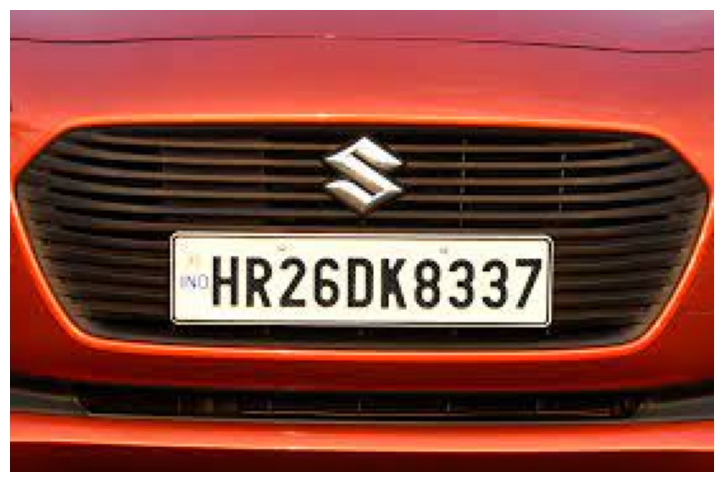

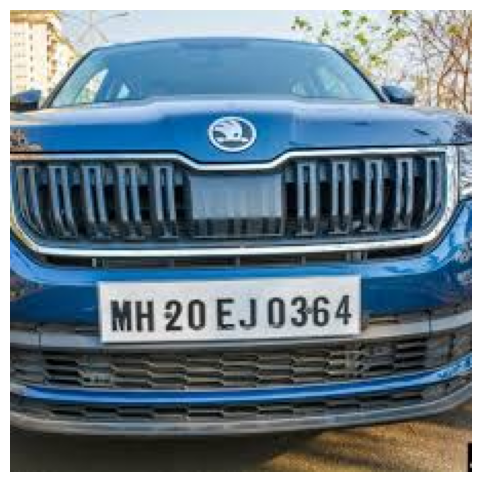

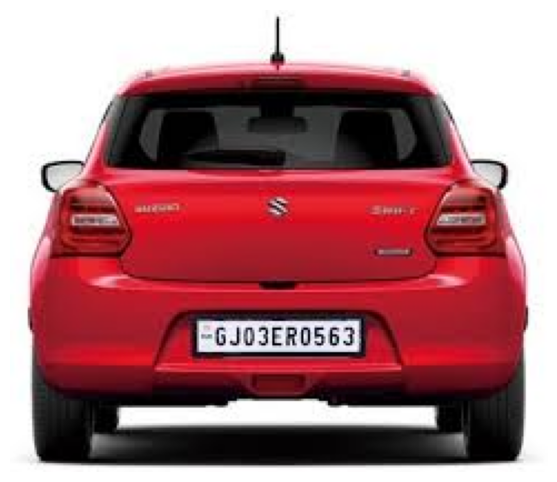

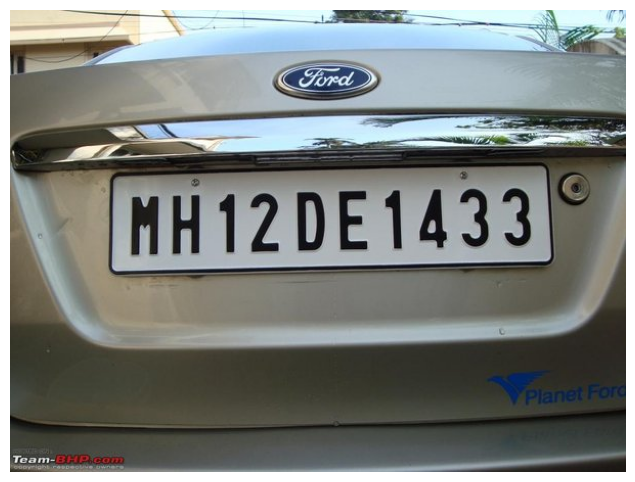

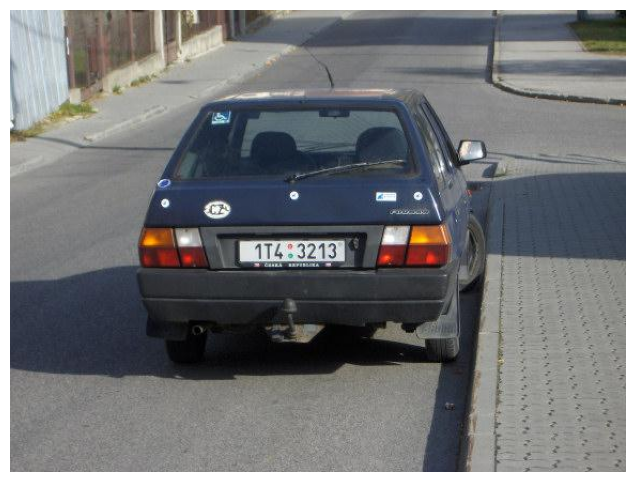

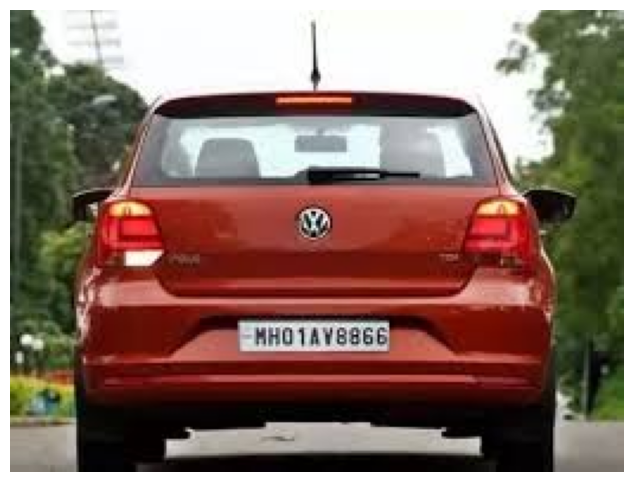

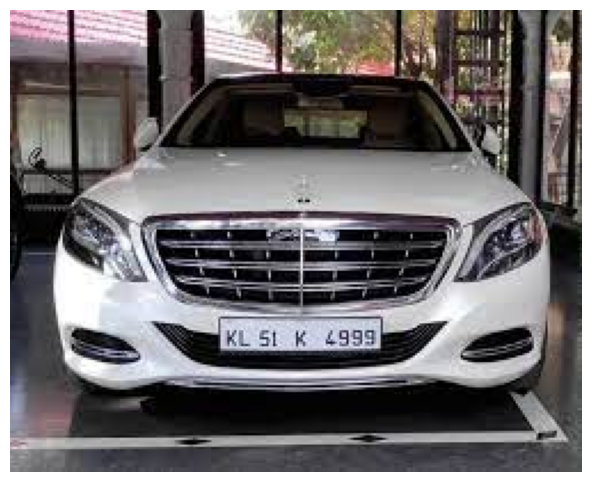

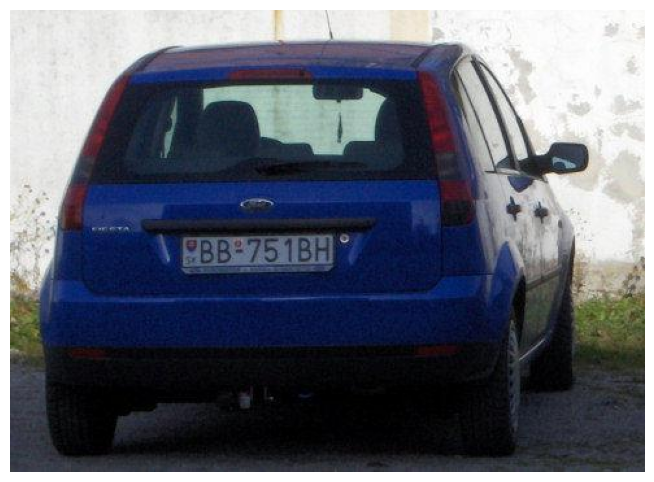

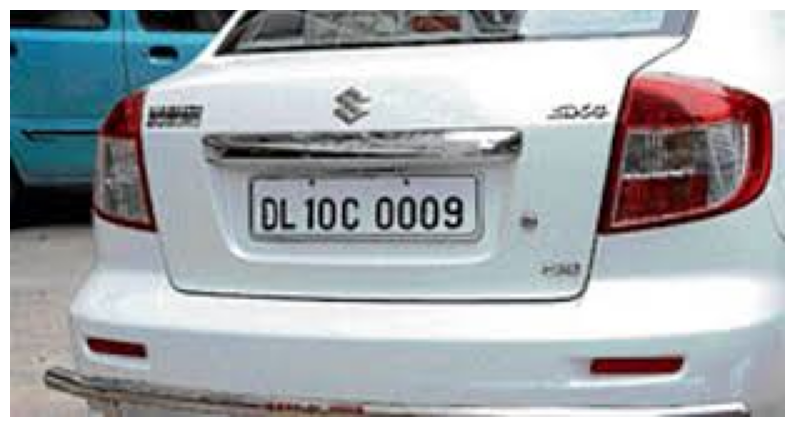

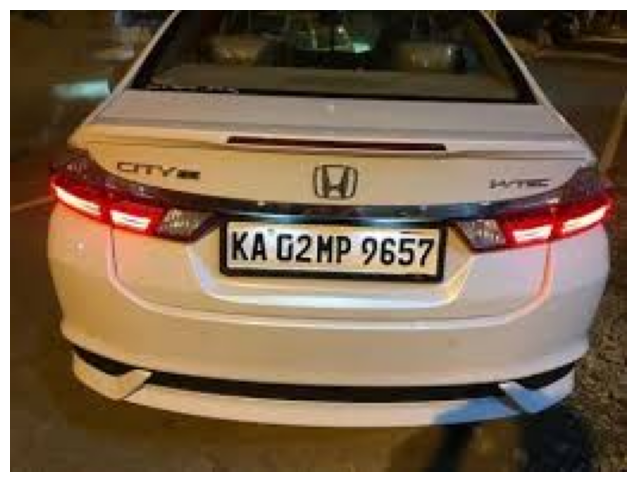

In [17]:
input_folder = "images"
images_list = process_images_in_folder(input_folder)

# Display all images in the list
for img in images_list:
    display(img)


In [18]:
model = tf.keras.models.load_model('Model1-25.h5')

In [19]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((96,96,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (96,96), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,96,96,3) #preparing image for the model
        y_ = model.predict(img)[0]
        classes_x = np.argmax(y_)
        character = dic[classes_x]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

# print(show_results())

In [20]:
number_plate_results = []
for img in images_list:
    output_img, plate = detect_plate(img)
    char = segment_characters(plate)
    for i in range(len(char)):
#         plt.subplot(1, 10, i+1)
        char[i] = 255 - char[i]
#         plt.imshow(char[i], cmap='gray')
#         plt.axis('off')
    number_plate_results.append(show_results(char))

1/1 [==============================] - 0s 40ms/step


In [21]:
#print(len(number_plate_results))
for plate in number_plate_results:
    print(plate)

HQ26DK8EE7
KH2DEJDAV
GJD3EQD563
MH1YDE1A
1S43213
KHD1UUBB66
4L54K499
887578H
DL40CDDD9
KAD2MOD657


In [22]:
def read_first_column(csv_file_path):
    column_items = []

    with open(csv_file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Assuming the first column is at index 0
            column_items.append(row[0])

    return column_items

# Example usage:
csv_file_path = 'NumberPlate.csv'  # Replace with the path to your CSV file
actual_plate_list = read_first_column(csv_file_path)

In [23]:
for plate in actual_plate_list:
    print(plate)

HR26DK8337
MH20EJ0364
GJ03ER0563
MH12DE1433
1T43213
MH01AY8866
KL51K4999
BB751BH
DL10C0009
KAG2MP9657


In [13]:
import Levenshtein

def calculate_accuracy(list1, list2):
    if len(list1) != len(list2):
        print(len(list1))
        print(len(list2))
        raise ValueError("Lists must be of equal length")

    total_items = len(list1)
    correct_predictions = 0

    for str1, str2 in zip(list1, list2):
        # Using Levenshtein distance as a similarity metric
        distance = Levenshtein.distance(str1, str2)
        similarity = 1 - (distance / max(len(str1), len(str2)))

        # You can set a threshold for similarity and consider it a correct prediction
        threshold = 0.8  # Adjust as needed
        if similarity >= threshold:
            correct_predictions += 1

    accuracy = correct_predictions / total_items
    return accuracy


accuracy = calculate_accuracy(actual_plate_list, number_plate_results)
print("Accuracy:", accuracy)

Accuracy: 0.1


In [58]:
class IndianNumberPlateResemblance:
    def __init__(self):
        self.resemblance_dict = {}

    def add_resemblance(self, char, resemblances):
        char = char.upper()
        if char not in self.resemblance_dict:
            self.resemblance_dict[char] = set(resemblances)
        else:
            self.resemblance_dict[char].update(resemblances)

    def get_resemblances(self, char):
        char = char.upper()
        return self.resemblance_dict.get(char, {char})

    def is_resemblance(self, char1, char2):
        char1 = char1.upper()
        char2 = char2.upper()
        return char2 in self.resemblance_dict.get(char1, set())

    def calculate_accuracy(self, actual, predicted):
        actual = actual.upper()
        predicted = predicted.upper()

        total_chars = len(actual)
        correct_chars = 0

        for char_actual in actual:
           correct_chars += any(char_pred == char_actual or char_pred in self.get_resemblances(char_actual) for char_pred in predicted)
        
        accuracy = correct_chars / total_chars
        return accuracy

    def calculate_final_accuracy(self, actual_strings, predicted_strings):
        if len(actual_strings) != len(predicted_strings):
            raise ValueError("Number of actual and predicted strings must be the same.")

        total_accuracy = 0

        for actual, predicted in zip(actual_strings, predicted_strings):
            if len(actual) == len(predicted):
                total_accuracy += self.calculate_accuracy(actual, predicted)
            else:
                # print("Handle case where lengths are not equal")
                total_chars = len(actual)
                correct_chars = 0

                for char_actual in actual:
                    # Increment correct_chars if the character or its resemblance is in the predicted string
                    correct_chars += any(char_pred == char_actual or char_pred in self.get_resemblances(char_actual) for char_pred in predicted)
                    
                if len(actual) > len(predicted):
                    correct_chars += 2 * (len(actual) - len(predicted));
                    
                accuracy = correct_chars / total_chars
                total_accuracy += accuracy

        final_accuracy = total_accuracy / len(actual_strings)
        return final_accuracy

# Example Usage
plate_resemblance = IndianNumberPlateResemblance()

# Adding resemblances
plate_resemblance.add_resemblance('B', ['8', 'E'])
plate_resemblance.add_resemblance('D', ['G', '0', 'O', '9'])
plate_resemblance.add_resemblance('E', ['3'])
plate_resemblance.add_resemblance('3', ['E'])
plate_resemblance.add_resemblance('Q', ['R'])
plate_resemblance.add_resemblance('R', ['Q'])
plate_resemblance.add_resemblance('M', ['K'])
plate_resemblance.add_resemblance('K', ['M'])
plate_resemblance.add_resemblance('A', ['4'])
plate_resemblance.add_resemblance('1', ['7'])

# Example strings to compare
actual_strings = actual_plate_list
predicted_strings = number_plate_results

final_accuracy = plate_resemblance.calculate_final_accuracy(actual_strings, predicted_strings)
print("Final Accuracy:", final_accuracy*100)


Final Accuracy: 88.57142857142856
